# Load libraries

In [1]:
import os

import opensim as osim
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath('../../analysis'))
from jam_analysis import JamAnalysis


# Set options

In [2]:
# Opensim / Simulation
# osim.Logger.setLevelString("Debug") # 'trace' was used for matlab
useVisualizer = False
integratorAccuracy = 1e-2
useActivationDynamics = True
useTendonCompliance = True
useMusclePhysiology = True


# Plotting:
fontsize = 20
linewidth = 2


# Set required filepaths, make folders, etc. 

In [3]:
# model_file = "../../../models/knee_healthy/lenhart2015/lenhart2015_test.osim";
model_file = "../../../models/knee_healthy/lenhart2015/lenhart2015.osim"
results_basename = "passive_flexion"
forsim_result_dir = "./results/forsim"
jnt_mech_result_dir = "./results/joint-mechanics"

### Create Input Files

os.makedirs("inputs", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("graphics", exist_ok=True)

prescribed_coord_file = "./inputs/prescribed_coordinates.sto"


# Setup information re: simulation "time"

In [4]:
# Simulation Time
# Simulation consists of two phases:
#   settle : allow unconstraind knee DOFs to settle into equilbrium 
#   flex : prescribe the tibiofemoral flexion
# All time units are in seconds 

time_step = 0.01

settle_duration = 0.5
flex_duration = 2.0

settle_time = np.arange(0,settle_duration,time_step)
flex_time = np.arange(settle_duration,flex_duration + settle_duration, time_step)

time = np.concatenate((settle_time, flex_time))

time_points = [0, settle_duration/2, settle_duration, settle_duration + flex_duration]

nSettleSteps = settle_time.shape[0]
nFlexSteps = flex_time.shape[0]
nTimeSteps = nSettleSteps + nFlexSteps

# Setup the prescribed knee flexion

In [5]:
# Prescribe Knee Flexion
max_knee_flex = 90

knee_flex = [0, 0, 0, max_knee_flex]

#would be better to use smooth spline interpolation here instead of linear
# smooth_knee_flex = np.reshape(np.interp(time,time_points,knee_flex),(nTimeSteps,1))

f = interp1d(time_points, knee_flex, kind='cubic')
smooth_knee_flex = np.reshape(f(time), (nTimeSteps, 1))

# Setup pelvis tilt

In [6]:
pelvis_tilt = np.ones((nSettleSteps+nFlexSteps,1))*90

# Combine time, and knee/pelvis kinematics into STO

In [7]:
time_std = osim.StdVectorDouble()
for t in np.nditer(time):
    time_std.push_back(float(t))

data_array = np.concatenate((smooth_knee_flex,pelvis_tilt),1)

data_matrix = osim.Matrix.createFromMat(data_array)

labels = osim.StdVectorString()

# labels.append("time")
labels.append("knee_flex_r")
labels.append("pelvis_tilt")

prescribed_coord_table = osim.TimeSeriesTable(time, data_matrix, labels)

sto = osim.STOFileAdapter();
sto.write(prescribed_coord_table,prescribed_coord_file);


# Plot simulation inputs

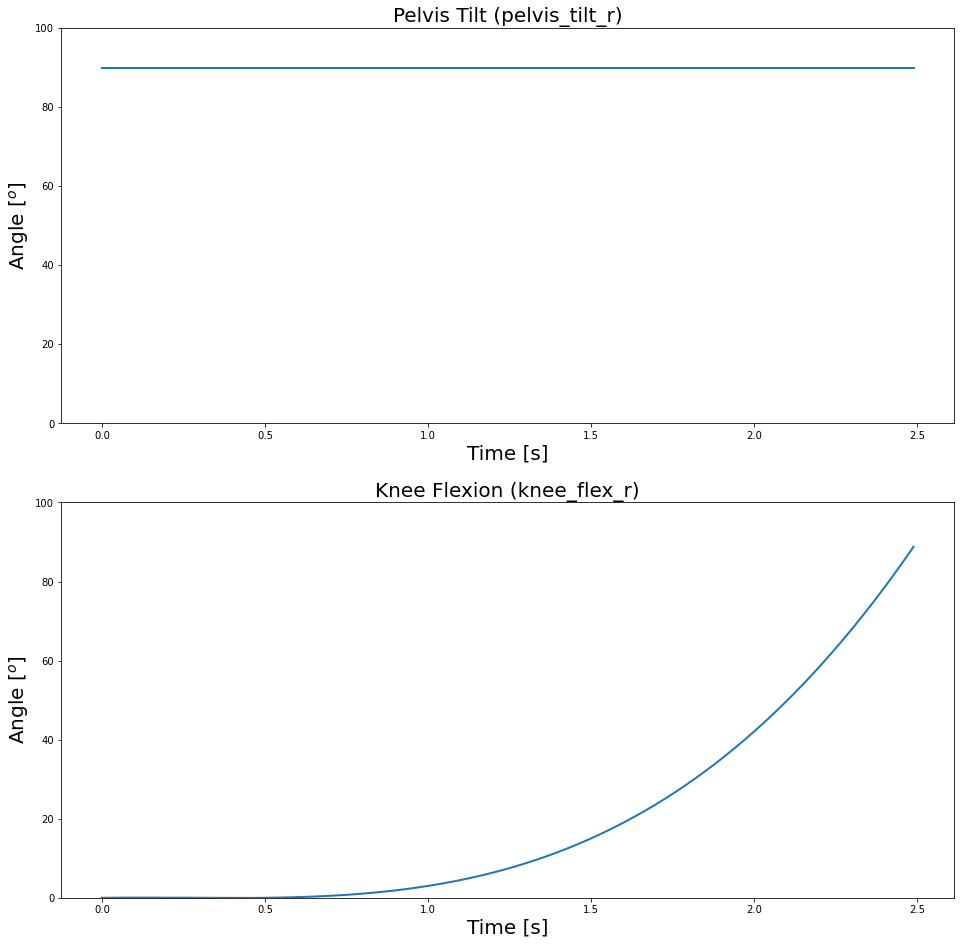

In [8]:
# %% Plot Simulation Inputs 
fig, ax = plt.subplots(2, figsize=(16,16))
# coord_fig = figure('name','prescribed_coordinates','Position',  [100, 100, 667, 300]);

ax[0].plot(time, pelvis_tilt, linewidth=linewidth)
ax[0].set_xlabel('Time [s]', fontsize=fontsize)
ax[0].set_ylabel(r'Angle [$^{o}$]', fontsize=fontsize)
ax[0].set_ylim([0, 100])
ax[0].set_title('Pelvis Tilt (pelvis_tilt_r)', fontsize=fontsize)

ax[1].plot(time, smooth_knee_flex, linewidth=linewidth)
ax[1].set_xlabel('Time [s]', fontsize=fontsize)
ax[1].set_ylabel(r'Angle [$^{o}$]', fontsize=fontsize)
ax[1].set_ylim([0, 100])
ax[1].set_title('Knee Flexion (knee_flex_r)', fontsize=fontsize)

os.makedirs('./results/graphics/', exist_ok=True)
fig.savefig('./results/graphics/prescribed_coordinates.png')

# Perform Simulation w/ ForsimTool

In [9]:
## Perform Simulation with ForsimTool
forsim = osim.ForsimTool()
forsim.set_model_file(model_file)
forsim.set_results_directory(forsim_result_dir)
forsim.set_results_file_basename(results_basename)
forsim.set_start_time(-1)
forsim.set_stop_time(-1)
forsim.set_integrator_accuracy(integratorAccuracy) # Note this should be 1e-6 for research
forsim.set_constant_muscle_control(0.02) # Set all muscles to 2% activation to represent passive state
forsim.set_override_default_muscle_activation(0.02);
forsim.set_use_activation_dynamics(useActivationDynamics);
forsim.set_use_tendon_compliance(useTendonCompliance);
forsim.set_use_muscle_physiology(useMusclePhysiology)
# forsim.set_ignore_activation_dynamics(True)
# forsim.set_ignore_tendon_compliance(True)
forsim.set_unconstrained_coordinates(0,'/jointset/knee_r/knee_add_r')
forsim.set_unconstrained_coordinates(1,'/jointset/knee_r/knee_rot_r')
forsim.set_unconstrained_coordinates(2,'/jointset/knee_r/knee_tx_r')
forsim.set_unconstrained_coordinates(3,'/jointset/knee_r/knee_ty_r')
forsim.set_unconstrained_coordinates(4,'/jointset/knee_r/knee_tz_r')
forsim.set_unconstrained_coordinates(5,'/jointset/pf_r/pf_flex_r')
forsim.set_unconstrained_coordinates(6,'/jointset/pf_r/pf_rot_r')
forsim.set_unconstrained_coordinates(7,'/jointset/pf_r/pf_tilt_r')
forsim.set_unconstrained_coordinates(8,'/jointset/pf_r/pf_tx_r')
forsim.set_unconstrained_coordinates(9,'/jointset/pf_r/pf_ty_r')
forsim.set_unconstrained_coordinates(10,'/jointset/pf_r/pf_tz_r')
forsim.set_prescribed_coordinates_file(prescribed_coord_file)
forsim.set_use_visualizer(useVisualizer)
forsim.printToXML('./inputs/forsim_settings.xml')

True

### Actually run the computational part

In [10]:
print('Running Forsim Tool...')
forsim.run()

Running Forsim Tool...
[critical] 
[critical] ==========
[critical] ForsimTool
[critical] ==========
[critical] 
[info] Loaded model lenhart2015 from file ../../../models/knee_healthy/lenhart2015/lenhart2015.osim
[info] Setting default muscle activation to: 0.02
[info] use_activation_dynamics: true
[info] use_tendon_compliance: true
[info] use_muscle_physiology : true
[info] 
[info] Constant Muscle Control: 0.02
[info] /forceset/addbrev_r
[info] /forceset/addlong_r
[info] /forceset/addmagProx_r
[info] /forceset/addmagMid_r
[info] /forceset/addmagDist_r
[info] /forceset/addmagIsch_r
[info] /forceset/bflh_r
[info] /forceset/bfsh_r
[info] /forceset/edl_r
[info] /forceset/ehl_r
[info] /forceset/fdl_r
[info] /forceset/fhl_r
[info] /forceset/gaslat_r
[info] /forceset/gasmed_r
[info] /forceset/gem_r
[info] /forceset/glmax1_r
[info] /forceset/glmax2_r
[info] /forceset/glmax3_r
[info] /forceset/glmed1_r
[info] /forceset/glmed2_r
[info] /forceset/glmed3_r
[info] /forceset/glmin1_r
[info] /forces

True

_r
[info] /forceset/grac_r
[info] /forceset/iliacus_r
[info] /forceset/pect_r
[info] /forceset/perbrev_r
[info] /forceset/perlong_r
[info] /forceset/pertert_r
[info] /forceset/piri_r
[info] /forceset/psoas_r
[info] /forceset/quadfem_r
[info] /forceset/recfem_r
[info] /forceset/sart_r
[info] /forceset/semimem_r
[info] /forceset/semiten_r
[info] /forceset/soleus_r
[info] /forceset/tfl_r
[info] /forceset/tibant_r
[info] /forceset/tibpost_r
[info] /forceset/vasint_r
[info] /forceset/vaslat_r
[info] /forceset/vasmed_r
[info] 
[info] Unconstrained Coordinates:
[info] /jointset/knee_r/knee_add_r
[info] /jointset/knee_r/knee_rot_r
[info] /jointset/knee_r/knee_tx_r
[info] /jointset/knee_r/knee_ty_r
[info] /jointset/knee_r/knee_tz_r
[info] /jointset/pf_r/pf_flex_r
[info] /jointset/pf_r/pf_rot_r
[info] /jointset/pf_r/pf_tilt_r
[info] /jointset/pf_r/pf_tx_r
[info] /jointset/pf_r/pf_ty_r
[info] /jointset/pf_r/pf_tz_r
[info] 
[info] Prescribed Coordinates:
[info] knee_flex_r
[info] pelvis_tilt
[info

# Perform Analysis with JointMechanicsTool

In [11]:
## Perform Analysis with JointMechanicsTool

jnt_mech = osim.JointMechanicsTool()
jnt_mech.set_model_file(model_file)
jnt_mech.set_input_states_file(forsim_result_dir + '/' + results_basename + '_states.sto')
jnt_mech.set_results_file_basename(results_basename)
jnt_mech.set_results_directory(jnt_mech_result_dir)
jnt_mech.set_use_activation_dynamics(useActivationDynamics);
jnt_mech.set_use_tendon_compliance(useTendonCompliance);
jnt_mech.set_use_muscle_physiology(useMusclePhysiology)
jnt_mech.set_start_time(-1)
jnt_mech.set_stop_time(-1)
jnt_mech.set_normalize_to_cycle(False)
jnt_mech.set_contacts(0,'all')
jnt_mech.set_ligaments(0,'all')
jnt_mech.set_muscles(0,'all')
jnt_mech.set_muscle_outputs(0,'all')
jnt_mech.set_attached_geometry_bodies(0,'/bodyset/femur_distal_r')
jnt_mech.set_attached_geometry_bodies(1,'/bodyset/tibia_proximal_r')
jnt_mech.set_attached_geometry_bodies(2,'/bodyset/patella_r')
jnt_mech.set_output_orientation_frame('ground')
jnt_mech.set_output_position_frame('ground')
jnt_mech.set_write_vtp_files(True)
jnt_mech.set_write_h5_file(True)
jnt_mech.set_h5_kinematics_data(True)
jnt_mech.set_h5_states_data(True)
jnt_mech.set_use_visualizer(useVisualizer)
jnt_mech.printToXML("./inputs/joint_mechanics_settings.xml")


True

### Actually run the computational part

In [12]:
jnt_mech.run()

[critical] 


True

[critical] ====================
[critical] Joint Mechanics Tool
[critical] ====================
[critical] 
[info] Loaded model lenhart2015 from file ../../../models/knee_healthy/lenhart2015/lenhart2015.osim
[info] Time: 0.0
[info] Time: 0.01
[info] Time: 0.02
[info] Time: 0.03
[info] Time: 0.04
[info] Time: 0.05
[info] Time: 0.06
[info] Time: 0.07
[info] Time: 0.08
[info] Time: 0.09
[info] Time: 0.1
[info] Time: 0.11
[info] Time: 0.12
[info] Time: 0.13
[info] Time: 0.14
[info] Time: 0.15
[info] Time: 0.16
[info] Time: 0.17
[info] Time: 0.18
[info] Time: 0.19
[info] Time: 0.2
[info] Time: 0.21
[info] Time: 0.22
[info] Time: 0.23
[info] Time: 0.24
[info] Time: 0.25
[info] Time: 0.26
[info] Time: 0.27
[info] Time: 0.28
[info] Time: 0.29
[info] Time: 0.3
[info] Time: 0.31
[info] Time: 0.32
[info] Time: 0.33
[info] Time: 0.34
[info] Time: 0.35
[info] Time: 0.36
[info] Time: 0.37
[info] Time: 0.38
[info] Time: 0.39
[info] Time: 0.4
[info] Time: 0.41
[info] Time: 0.42
[info] Time: 0.43
[info

# Analyze Simulation Results

# Plot results

In [ ]:
jam = JamAnalysis()
jam.jam_analysis([os.path.join(jnt_mech_result_dir, results_basename + '.h5')])

files: ./results/joint-mechanics/passive_flexion_glmin3_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_grac_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_iliacus_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_pect_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_perbrev_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_perlong_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_pertert_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_piri_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_psoas_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_quadfem_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_recfem_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_sart_r
[info] Writing .vtp files: ./results/joint-mechanics/passive_flexion_semimem_r
[info] Wr

### Secondary Kinematics

In [ ]:
# Secondary Kinematics
sec_coords = [
    'knee_flex_r', 'knee_add_r', 'knee_rot_r',
    'knee_tx_r', 'knee_ty_r', 'knee_tz_r',
    'pf_flex_r', 'pf_rot_r', 'pf_tilt_r',
    'pf_tx_r','pf_ty_r','pf_tz_r'
]

rows = 4
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(16*3, 4*12))
for idx, outcome in enumerate(sec_coords):
    row_ = idx // cols
    col_ = idx % cols
    ax[row_, col_].plot(jam.coordinateset[outcome]['value'], linewidth=5)
    ax[row_, col_].set_title(outcome, fontsize=fontsize*3)
    ax[row_, col_].xaxis.set_tick_params(labelsize=fontsize*2)
    ax[row_, col_].yaxis.set_tick_params(labelsize=fontsize*2)

fig.suptitle('Secondary Kinematics', fontsize=fontsize*4)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('./results/graphics/secondary_kinematics.png')

### Ligament Forces

In [ ]:
# Ligament Forces
ligament_names = [
    'MCLd','MCLs',
    'LCL',
    'ACLam', 'ACLpl',
    'PCLal', 'PCLpm',
    'PT',
    'ITB'
]

rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(16*cols, (rows+1)*12))
fig.suptitle('Ligament Forces', fontsize=fontsize*4)

for idx, outcome in enumerate(ligament_names):
    row_ = idx // cols
    col_ = idx % cols
    
    fibers = [x for x in jam.forceset['Blankevoort1991Ligament'].keys() if outcome in x]
    
    data = np.zeros(jam.forceset['Blankevoort1991Ligament'][fibers[0]]['total_force'].shape[0])
    for fiber in fibers:
        data += np.squeeze(jam.forceset['Blankevoort1991Ligament'][fiber]['total_force'])
    ax[row_, col_].plot(data, linewidth=5)
    ax[row_, col_].set_title(outcome, fontsize=fontsize*3)
    ax[row_, col_].xaxis.set_tick_params(labelsize=fontsize*2)
    ax[row_, col_].yaxis.set_tick_params(labelsize=fontsize*2)
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('./results/graphics/ligament_forces.png')

### Plot Muscle Tendon Outputs

In [ ]:
muscles = [
    'vasmed_r','recfem_r','glmax1_r','glmax2_r','glmax3_r','soleus_r','vaslat_r'
]

muscle_outcomes = [
    'actuation',
    'active_fiber_force',
    'passive_fiber_force',
    'tendon_strain',
    'normalized_fiber_length',
    'length'
]

rows = 2
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(16*cols, (rows+1)*12))

fig.suptitle('Muscle-Tendon Outputs', fontsize=fontsize*3.5)

# ACTUATION
for outcome_idx, muscle_outcome in enumerate(muscle_outcomes):
    row_ = outcome_idx // cols
    col_ = outcome_idx % cols
    for idx, muscle in enumerate(muscles):
        jam.plot_muscle_output(
            muscle, 
            muscle_outcome, 
            ax=ax[row_, col_], 
            linewidth=5, 
            fontsize=fontsize*3,
            label=muscle
        )
    ax[row_, col_].set_ylabel(muscle_outcome, fontsize=fontsize*3)
    ax[row_, col_].xaxis.set_tick_params(labelsize=fontsize*2)
    ax[row_, col_].yaxis.set_tick_params(labelsize=fontsize*2)
    if outcome_idx == 2:
        ax[row_, col_].legend(fontsize=fontsize*2)
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('./results/graphics/muscle_tendon_outputs.png')

In [ ]:
! jupyter nbconvert --to html examplePassiveFlexion.ipynb